# 『Deep Residual Learning for Image Recognition』 논문 재현

<br>

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; 모델의 깊이가 깊어질수록 성능 저하가 발생하는 'Degradation' 문제를 해결하기 위해 Kaiming He 외 3인이 『Deep Residual Learning for Image Recognition 』에서 제시한 'Plain' 모델과 'Residual' 모델의 성능 비교를, Tensorlflow에서 제공하는 'Cats_vs_Dogs' 데이터셋을 이용하여 재현하였다. 데이터셋은 고양이, 개 이미지-레이블 쌍으로 구성된 데이터셋으로 학습 데이터 19,773개, 테스트 데이터 3,489개이다. 이미지를 모두 224 x 224로 리사이즈하고 Min-Max 정규화 전처리를 수행하였다. 'Plain-34', 'Plain-50', 'Res-34', 'Res-50' 네 개의 모델을 사용하였으며, 모두 배치 크기는 32로 설정하고 옵티마이저는 Adam을 사용하여 총 30회 학습하였다. 테스트 데이터셋에 대한 Epoch 30회 중 가장 낮은 손실값과 마지막 5회의 손실값 평균을 비교하였다. 학습 결과 테스트 데이터셋에 대한 30회 중 손실값은 'Resi-50`이 0.2257, 'Resi-34'가 0.2548, 'Plain-34'가 0.3163, 'Plain-50'이 0.6902 순으로 낮았다. 최종 5회의 손실값 평균 또한 해당 모델 순으로 낮음을 확인하였다. 나아가 'Plain-50' 모델의 학습 데이터셋에 대한 손실값과 테스트 데이터셋에 대한 손실값 변화 바탕으로, 두 데이터셋의 손실값 모두 특정 Epoch에서 더이상 감소하지 않은 것을 바탕으로 과적합이 원인이 아님을 확인하였다. 최종적으로 'Plain-50' 모델이 'Plain-34' 모델에 비해 층이 깊음에도 불구하고 손실값이 높은 것을 통해 'Degradation' 문제가 존재하였으며, 이를 'Deep Residual Learning' 기법을 적용한 'Res-34'와 'Res-50' 모델을 통해 해결할 수 있음을 확인하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 일반적으로 모델은 깊을수록 그 성능이 증가하는 것이 통념입니다. 하지만 특정 층 이상이 되면 오히려 성능이 감소하는 'Degradation' 문제가 발생합니다. 이는 과적합이 아닌 경사 소실 또는 폭발에 기인합니다. Kaiming He 외 3인은 해당 문제를 해결할 수 있는 방안으로 'Deep Residual Learning'을 제시하였습니다. 본 예제에서는 Kaiming He 외 3인이 『Deep Residual Learning for Image Recognition
』에서 제시한 'Plain' 모델과 'Residual' 모델의 성능 비교를, Tensorlflow에서 제공하는 'Cats_vs_Dogs' 데이터셋을 이용하여 재현하고자 합니다. 
</span><br><br>

> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. 모델 생성_
>
> _4. 모델 학습 및 평가_

<br><br>

_**<span style="color:red">※본 예제는 LMS 클라우드가 아닌 로컬에서 진행되어 학습 속도 및 결과 등이 상이할 수 있습니다.</span>**_
***

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리를 호출합니다.
***

In [1]:
import tensorflow as tf
import tensorflow.keras as K
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델을 생성하고 학습하기 이전에 주어진 데이터를 분석하고자 합니다. 데이터 분석을 통해 데이터의 특성을 알고 이를 통해 데이터를 적절하게 정제하거나 알맞은 모델을 설계할 수 있습니다. 따라서 우선적으로 주어진 데이터셋의 기본적인 정보부터 구체적인 특징까지 파악한 이후 프로젝트를 진행할 필요가 있습니다.
</span><br><br>
    
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서 사용하는 데이터는 Tensorflow에서 제공하는 120 품종의 개 이미지 - 레이블 쌍으로 이루어진 'stanford_dogs' 데이터셋 입니다. 학습 데이터 12,000개, 테스트 데이터 8,580개입니다. 분석 결과 입력 데이터는 0에서 255 사이의 int8 형식의 이미지 이며, 각 이미지의 크기가 상이하였습니다.
</span>

***

<br>

#### 데이터셋 불러오기
***
+ 예제에 사용되는 학습 데이터를 불러온다.


+ Tensorflow에서 제공하는 120종의 개 이미지로 이루어진 `stanford_dogs` 데이터셋을 사용한다.
***

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir='Y:/projects/gitProjects/aiffel_going_deeper_cv/datasets/gd_04/'
)

NUM_CLASSES = ds_info.features['label'].num_classes

<br>

#### 데이터셋 기본 정보 확인
***
+ 학습 데이터 12,000개, 테스트 데이터 8,580개 이다.


+ 입력 데이터는 `int8` 형식의 사이즈가 다른 컬러 이미지이다.


+ 클래스 레이블은 총 120개 이다.
***

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='Y:/projects/gitProjects/aiffel_going_deeper_cv/datasets/gd_04/stanford_dogs\\0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),


<br>

#### 데이터셋 샘플 시각화
***
+ 데이터셋 이미지를 시각화 한다.


+ 각 이미지의 사이즈가 상이한 것을 확인할 수 있다.


+ 품종 명과 그에 해당하는 클래스 번호를 확인할 수 있다.
***

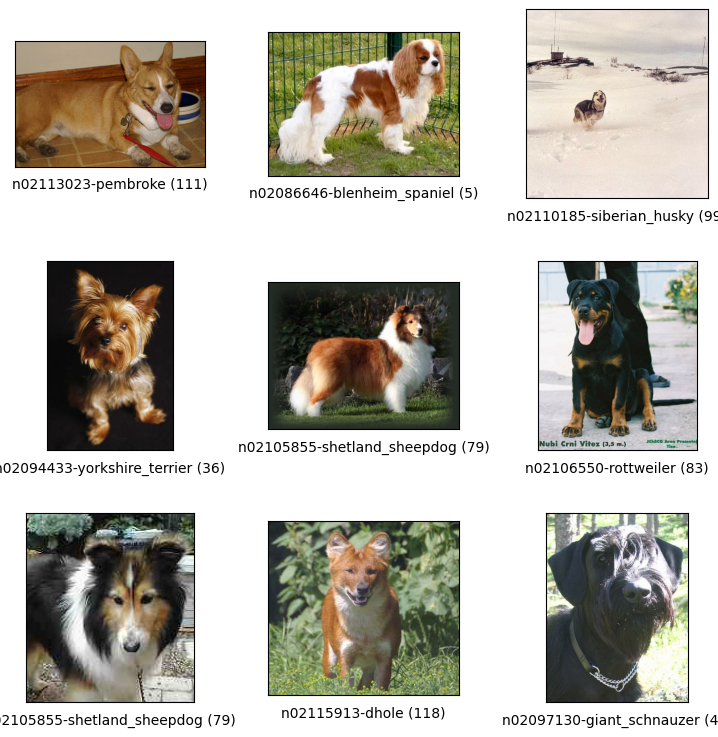

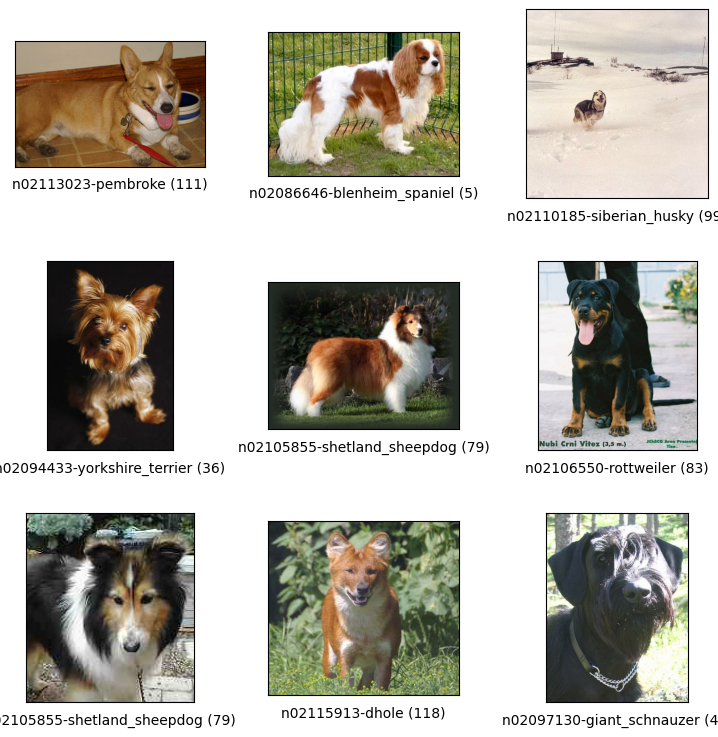

In [11]:
tfds.show_examples(ds_train, ds_info)

<br>

## 3. 데이터 증강
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞선 데이터 분석 단계에서 확인한 사항을 바탕으로 전처리를 수행합니다. 이미지 별 사이즈가 달랐으므로 모두 224 x 224 크기로 변환하여준 후 Min-Max 정규화를 수행합니다. 최종적으로 전처리 후 배치 사이즈 16으로 이루어진 데이터셋을 생성합니다.
</span>

***

#### Mixup
***
+ 이미지 사이즈 변환 및 정규화 함수 `normalize_and_resize_img`와 데이터셋 생성 함수 `apply_normalize_on_dataset`를 정의합니다.
***

In [4]:
#function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1-ratio) * image_a + ratio * image_b
    mixed_label = (1-ratio) * label_a + ratio * label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

<br>

#### 전처리 및 데이터셋 생성 수행
***
+ 학습 데이터와 테스트 데이터에 대한 전처리와 데이터셋 생성을 수행합니다.


+ 배치 사이즈는 GPU 메모리 크기를 고려하여 32로 설정 하였습니다.
***

In [ ]:
def get_clip_box(image_a):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    #get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    
    #get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    #clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    middle_left = image_a[y_min:y_max, 0:x_min, :] #image_b left outer bound
    middle_center = image_b[y_min:y_max, x_min:x_max, :] #image_b inner bound
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] #image_b right outer bound
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio) * label_a + ratio * label_b
    return mixed_label

def cutmix(image, label, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        x_min, y_min, x_max, y_max = get_clip_box(image_a)
        
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
        
    if with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    
    if with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    
    ds = ds.repeat()
    if not with_cutmix and not with_mixup:
        ds = ds.map(onehot, num_parallel_calls=2)
    else:
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
BATCH_SIZE = 32
EPOCH = 20

In [13]:
ds_train_ori = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, batch_size=BATCH_SIZE)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True, batch_size=BATCH_SIZE)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True, batch_size=BATCH_SIZE)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

<br>

## 4. 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 단순하게 층을 쌓은 'Plain' 모델과 'Residual' 모델을 생성합니다. 또한 각 층을 34, 50으로 구분하여 최종적으로 'Plain-34', 'Plain-50', 'Res-34', 'Res-50' 총 네 개의 모델을 생성하고 학습합니다. 배치 크기는 GPU 메모리 크기를 고려하여 32로 설정합니다. 옵티마이저는 'Adam'을 사용하여 총 30회 학습합니다.
</span>

***

#### 모델 생성 함수 정의
***
+ ResNet-34, ResNet-50 그리고 Plain 모델을 생성하는 `build_reset` 함수 정의합니다.
***

In [14]:
lr_scheduler = LearningRateScheduler(lambda epoch: 0.001 * 0.1 ** (epoch//6), verbose=0)

In [15]:
#Model address: C:\Users\yagi\.keras\models
def getModel():
    model = K.models.Sequential([
        K.applications.ResNet50V2(
            include_top=False,
            weights='imagenet', #'imagenet'
            input_shape=(224, 224, 3),
            pooling='avg' #'avg'
        ),
        K.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=K.optimizers.SGD(momentum=0.9), 
        metrics=['accuracy']
    )
    return model

In [17]:
model = getModel()

his_ori = model.fit(
    ds_train_ori,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[lr_scheduler]
)

Epoch 1/20
375/375 [==============================] - 42s 93ms/step - loss: 2.6140 - accuracy: 0.3918 - val_loss: 1.3179 - val_accuracy: 0.6255
Epoch 2/20
375/375 [==============================] - 34s 90ms/step - loss: 0.8428 - accuracy: 0.7748 - val_loss: 1.1694 - val_accuracy: 0.6607
Epoch 3/20
375/375 [==============================] - 34s 89ms/step - loss: 0.3238 - accuracy: 0.9327 - val_loss: 1.1438 - val_accuracy: 0.6730
Epoch 4/20
375/375 [==============================] - 34s 91ms/step - loss: 0.1368 - accuracy: 0.9841 - val_loss: 1.1224 - val_accuracy: 0.6833
Epoch 5/20
375/375 [==============================] - 34s 91ms/step - loss: 0.0617 - accuracy: 0.9958 - val_loss: 1.1304 - val_accuracy: 0.6824
Epoch 6/20
375/375 [==============================] - 34s 91ms/step - loss: 0.0376 - accuracy: 0.9972 - val_loss: 1.0824 - val_accuracy: 0.6926
Epoch 7/20
375/375 [==============================] - 34s 90ms/step - loss: 0.0268 - accuracy: 0.9991 - val_loss: 1.0460 - val_accuracy:

In [19]:
model = getModel()

his_aug = model.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[lr_scheduler]
)

Epoch 1/20
375/375 [==============================] - 38s 93ms/step - loss: 2.6747 - accuracy: 0.3864 - val_loss: 1.3908 - val_accuracy: 0.6026
Epoch 2/20
375/375 [==============================] - 45s 120ms/step - loss: 1.0196 - accuracy: 0.7155 - val_loss: 1.1925 - val_accuracy: 0.6556
Epoch 3/20
375/375 [==============================] - 64s 170ms/step - loss: 0.5902 - accuracy: 0.8404 - val_loss: 1.0375 - val_accuracy: 0.7020
Epoch 4/20
375/375 [==============================] - 66s 175ms/step - loss: 0.3535 - accuracy: 0.9146 - val_loss: 1.1338 - val_accuracy: 0.6693
Epoch 5/20
375/375 [==============================] - 66s 177ms/step - loss: 0.2168 - accuracy: 0.9538 - val_loss: 1.0399 - val_accuracy: 0.7104
Epoch 6/20
375/375 [==============================] - 67s 179ms/step - loss: 0.1397 - accuracy: 0.9750 - val_loss: 1.0726 - val_accuracy: 0.6992
Epoch 7/20
375/375 [==============================] - 68s 181ms/step - loss: 0.0897 - accuracy: 0.9869 - val_loss: 0.9814 - val_acc

In [21]:
model = getModel()

his_mixup = model.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[lr_scheduler]
)

Epoch 1/20
375/375 [==============================] - 53s 126ms/step - loss: 4.1869 - accuracy: 0.1532 - val_loss: 2.2337 - val_accuracy: 0.3979
Epoch 2/20
375/375 [==============================] - 46s 123ms/step - loss: 3.2573 - accuracy: 0.3678 - val_loss: 1.7443 - val_accuracy: 0.5333
Epoch 3/20
375/375 [==============================] - 47s 127ms/step - loss: 2.9710 - accuracy: 0.4630 - val_loss: 1.5338 - val_accuracy: 0.5830
Epoch 4/20
375/375 [==============================] - 47s 126ms/step - loss: 2.8111 - accuracy: 0.5093 - val_loss: 1.4289 - val_accuracy: 0.5989
Epoch 5/20
375/375 [==============================] - 47s 127ms/step - loss: 2.7243 - accuracy: 0.5552 - val_loss: 1.4632 - val_accuracy: 0.5975
Epoch 6/20
375/375 [==============================] - 48s 128ms/step - loss: 2.5713 - accuracy: 0.6067 - val_loss: 1.3424 - val_accuracy: 0.6294
Epoch 7/20
375/375 [==============================] - 46s 122ms/step - loss: 2.4449 - accuracy: 0.6562 - val_loss: 1.2017 - val_ac

In [23]:
model = getModel()

his_cutmix = model.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[lr_scheduler]
)

Epoch 1/20
375/375 [==============================] - 51s 122ms/step - loss: 4.3443 - accuracy: 0.1122 - val_loss: 2.2297 - val_accuracy: 0.4272
Epoch 2/20
375/375 [==============================] - 46s 123ms/step - loss: 3.4324 - accuracy: 0.3125 - val_loss: 1.7140 - val_accuracy: 0.5343
Epoch 3/20
375/375 [==============================] - 52s 138ms/step - loss: 3.1192 - accuracy: 0.3995 - val_loss: 1.5130 - val_accuracy: 0.5774
Epoch 4/20
375/375 [==============================] - 48s 127ms/step - loss: 2.8987 - accuracy: 0.4637 - val_loss: 1.4663 - val_accuracy: 0.5938
Epoch 5/20
375/375 [==============================] - 46s 122ms/step - loss: 2.8087 - accuracy: 0.4955 - val_loss: 1.3568 - val_accuracy: 0.6201
Epoch 6/20
375/375 [==============================] - 46s 123ms/step - loss: 2.7137 - accuracy: 0.5233 - val_loss: 1.3842 - val_accuracy: 0.6215
Epoch 7/20
375/375 [==============================] - 48s 129ms/step - loss: 2.6019 - accuracy: 0.5640 - val_loss: 1.1211 - val_ac

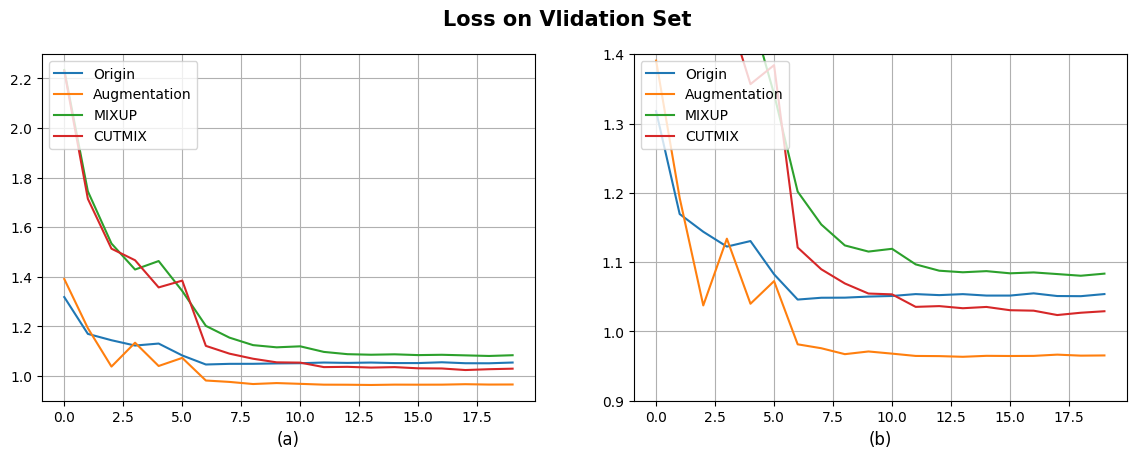

In [2]:
def drawGraph():
    plt.plot(his_ori['val_loss'])
    plt.plot(his_aug['val_loss'])
    plt.plot(his_mixup['val_loss'])
    plt.plot(his_cutmix['val_loss'])
    plt.legend(['Origin', 'Augmentation', 'MIXUP', 'CUTMIX'], loc='upper left')
    plt.grid(True)
    

plt.figure(figsize=(14, 4.5))
plt.suptitle('Loss on Vlidation Set', fontsize=15, fontweight ='bold')

plt.subplot(1, 2, 1)
drawGraph()
plt.xlabel('(a)', fontsize=12)

plt.subplot(1, 2, 2)
drawGraph()
plt.ylim(0.9, 1.40)
plt.xlabel('(b)', fontsize=12)

plt.show()

In [7]:
def build_reset(input_shape, is_50=False, is_resi=True):
    def ConvBlock(x, filters, kernel_size, strides=1, is_activation=True):
        out = K.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding='same',
            activation=None
        )(x)
        out = K.layers.BatchNormalization()(out)
        if is_activation:
            out = K.layers.Activation(activation='ReLU')(out)
        return out
    
    def head_layer(x):
        out = ConvBlock(x, filters=64, kernel_size=7, strides=2, is_activation=True)
        out_up = K.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(out)
        return out_up
    
    def res_block(x, filter_list, kernel_list, is_resi=True, short_cut=None, is_maxpool=False):
        out = x
        layer_size = len(kernel_list)
        for layer_idx in range(layer_size):
            filters = filter_list[layer_idx]
            kernel = kernel_list[layer_idx]
            
            is_last = True if (layer_idx + 1) == layer_size else False
            strides = 2 if layer_idx == 0 and is_maxpool else 1

            out = ConvBlock(out, filters=filters, kernel_size=kernel, is_activation=not is_last, strides=strides)
        
        if is_resi:
            if short_cut is not None:
                x = short_cut
            out = K.layers.Add()((out, x))
        out = K.layers.Activation(activation='ReLU')(out)
        return out

    def res_floor(x, filter_list, kernel_list, block_num, is_resi, short_strides=None):
        for block_idx in range(block_num):
            is_maxpool = False
            out_short = None
            if is_resi:
                if block_idx==0 and short_strides is not None:
                    last_filters = filter_list[-1]
                    out_short = ConvBlock(x, filters=last_filters, kernel_size=1, strides=short_strides, is_activation=False)
                    
                
            if block_idx==0 and short_strides==2:
                is_maxpool = True     
                
            x = res_block(
                x,
                filter_list=filter_list,
                kernel_list=kernel_list,
                is_resi=is_resi,
                short_cut=out_short,
                is_maxpool=is_maxpool
            )
        return x
    
    
    args = {
        'small': (
            ((3, 3), ) * 4, #kernel
            ((64, 64), (128, 128), (256, 256), (512, 512)), #filter
            (None, 2, 2, 2) #short_stride
        ),
        'big': (
            ((1, 3, 1), ) * 4,
            ((64, 64, 256), (128, 128, 512), (256, 256, 1024), (512, 512, 2048)),
            (1, 2, 2, 2)
        )
    }
    common_block_num_list = (3, 4, 6, 3)
    kernel_list, filter_list, short_stride_list = args['big'] if is_50 else args['small']
    args_iter = zip(filter_list, kernel_list, common_block_num_list, short_stride_list)
        
    
    input_layer = K.Input(shape=input_shape)
    out = head_layer(input_layer)
    
    for filter_li, kernel_li, block_num, short_stride in args_iter:
        out = res_floor(
            out,
            filter_list=filter_li,
            kernel_list=kernel_li,
            block_num=block_num,
            is_resi=is_resi,
            short_strides=short_stride
        )
    
    out = K.layers.AveragePooling2D(pool_size=2, padding='same')(out)
    out = K.layers.Flatten()(out)
    out = K.layers.Dense(units=2, activation='softmax')(out)

    model = K.models.Model(inputs=input_layer, outputs=out)
    return model

In [8]:
EPOCH = 30

<br>

### 4.1. ResNet-34
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ResNet-34 모델을 생성하고 'cats_vs_dogs' 데이터셋을 학습하여 모델을 평가합니다. 배치 사이즈를 32로 설정하여 총 20회 학습하였습니다. 그 결과, 학습 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.0204, 최저는 0.0163입니다. 테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.8874, 최저는 0.2548입니다. 데이터셋에 대한 정확도의 경우 최종 Epoch일 때가 가장 높았으며 0.9823입니다. 테스트 데이터셋에 대한 정확도는 최종 Epoch일 때 0.8846, 최고는 0.9217입니다.
   
</span>

<br><br>

<center><b>&lt;TRAIN 데이터셋에 대한 모델 결과></b></center>

|TRAIN Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.0204|0.9823|
|**Best**|0.0163|0.9823|

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.8874|0.8846|
|**Best**|0.2548|0.9217|

***

<br>

#### 모델 생성 및 요약 시각화
***
+ Resi-34 모델을 생성하고 모델 요약을 시각화 합니다.
***

In [9]:
model = build_reset(input_shape=(224, 224, 3), is_50=False, is_resi=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

<br>

#### 모델 레이어 시각화
***
+ Resi-34 모델 구조를 시각화 합니다.
***

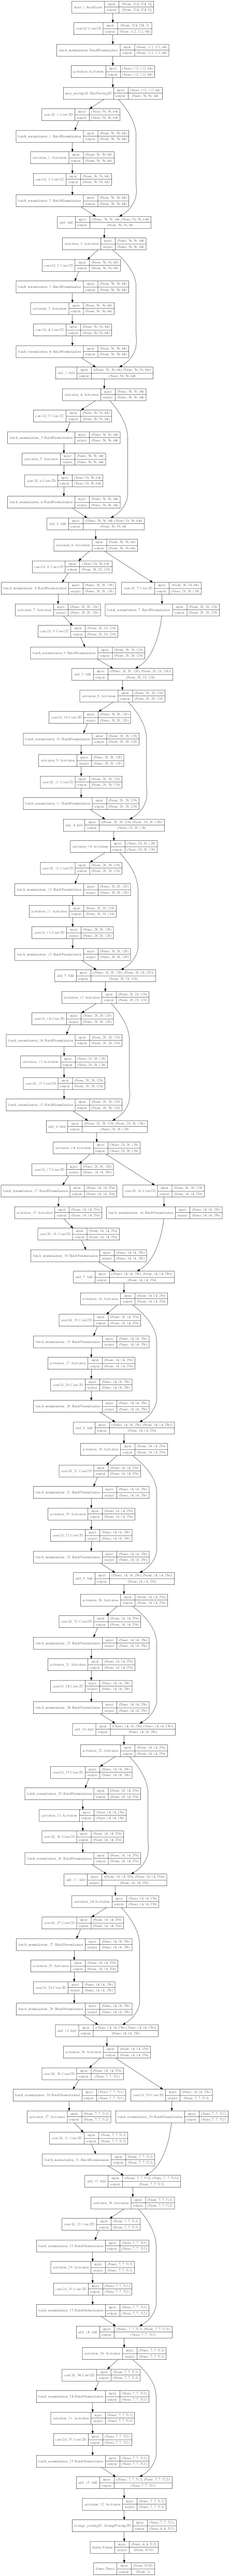

In [10]:
plot_model(model, show_shapes=True, dpi=36)

<br>

#### 모델 학습
***
+ Resi-34 모델을 학습합니다.


+ 손실 함수와 옵티마이저를 설정합니다.
***

In [11]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

res_34_his = model.fit(
    ds_train,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(test_size/BATCH_SIZE),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
617/617 - 47s - loss: 1.1838 - accuracy: 0.5376 - val_loss: 44.4338 - val_accuracy: 0.5094
Epoch 2/30
617/617 - 36s - loss: 0.7398 - accuracy: 0.5942 - val_loss: 0.7276 - val_accuracy: 0.5616
Epoch 3/30
617/617 - 36s - loss: 0.6036 - accuracy: 0.6787 - val_loss: 0.6636 - val_accuracy: 0.6535
Epoch 4/30
617/617 - 36s - loss: 0.5470 - accuracy: 0.7206 - val_loss: 0.6927 - val_accuracy: 0.6281
Epoch 5/30
617/617 - 36s - loss: 0.5154 - accuracy: 0.7444 - val_loss: 1.0474 - val_accuracy: 0.5542
Epoch 6/30
617/617 - 36s - loss: 0.4815 - accuracy: 0.7688 - val_loss: 0.7263 - val_accuracy: 0.5988
Epoch 7/30
617/617 - 36s - loss: 0.4444 - accuracy: 0.7894 - val_loss: 0.5149 - val_accuracy: 0.7530
Epoch 8/30
617/617 - 36s - loss: 0.3870 - accuracy: 0.8212 - val_loss: 0.4274 - val_accuracy: 0.8033
Epoch 9/30
617/617 - 37s - loss: 0.3390 - accuracy: 0.8501 - val_loss: 0.3852 - val_accuracy: 0.8533
Epoch 10/30
617/617 - 36s - loss: 0.2721 - accuracy: 0.8830 - val_loss: 0.4610 - val_accur

<br>

### 4.2. ResNet-50
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ResNet-50 모델을 생성, 학습하고 평가합니다. 마찬가지로 배치 사이즈를 32로 설정하여 총 20회 학습하였습니다. 그 결과, 학습 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.0491, 최저는 0.0313입니다. 정확도의 경우 최종 Epoch일 때 0.9835, 최고일 때 0.9881입니다.
    테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.2315, 최저는 0.2257입니다. 정확도의 경우 최종 Epoch일 때 가장 높았으며 0.9306입니다.
</span>

<br><br>

<center><b>&lt;TRAIN 데이터셋에 대한 모델 결과></b></center>

|TRAIN Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.0491|0.9835|
|**Best**|0.0313|0.9881|

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.2315|0.9306|
|**Best**|0.2257|0.9306|

***

<br>

#### 모델 생성 및 요약 시각화
***
+ Resi-50 모델을 생성하고 모델 요약을 시각화 합니다.
***

In [12]:
model = build_reset(input_shape=(224, 224, 3), is_50=True, is_resi=True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

<br>

#### 모델 레이어 시각화
***
+ Resi-50 모델 구조를 시각화 합니다.
***

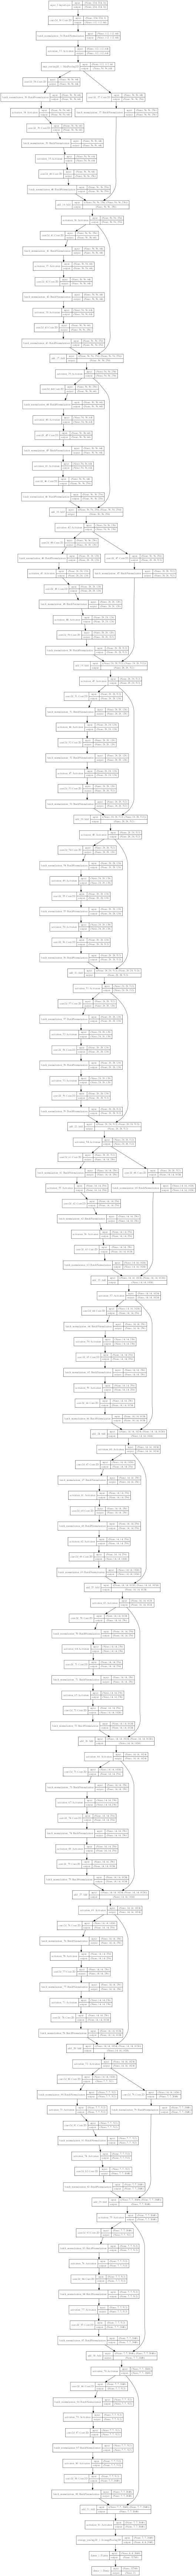

In [13]:
plot_model(model, show_shapes=True, dpi=36)

<br>

#### 모델 학습
***
+ Resi-50 모델을 학습합니다.


+ 손실 함수와 옵티마이저를 설정합니다.
***

In [14]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

res_50_his = model.fit(
    ds_train,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(test_size/BATCH_SIZE),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
617/617 - 66s - loss: 1.6098 - accuracy: 0.5285 - val_loss: 0.8755 - val_accuracy: 0.5430
Epoch 2/30
617/617 - 59s - loss: 0.7178 - accuracy: 0.6116 - val_loss: 0.6851 - val_accuracy: 0.6483
Epoch 3/30
617/617 - 58s - loss: 0.5857 - accuracy: 0.6919 - val_loss: 0.6491 - val_accuracy: 0.6979
Epoch 4/30
617/617 - 58s - loss: 0.5520 - accuracy: 0.7160 - val_loss: 0.9366 - val_accuracy: 0.5442
Epoch 5/30
617/617 - 58s - loss: 0.5286 - accuracy: 0.7355 - val_loss: 0.6278 - val_accuracy: 0.7035
Epoch 6/30
617/617 - 58s - loss: 0.4959 - accuracy: 0.7571 - val_loss: 0.6832 - val_accuracy: 0.6702
Epoch 7/30
617/617 - 58s - loss: 0.4574 - accuracy: 0.7866 - val_loss: 0.7525 - val_accuracy: 0.6963
Epoch 8/30
617/617 - 58s - loss: 0.4370 - accuracy: 0.7975 - val_loss: 0.8588 - val_accuracy: 0.6198
Epoch 9/30
617/617 - 58s - loss: 0.4149 - accuracy: 0.8091 - val_loss: 0.5558 - val_accuracy: 0.7197
Epoch 10/30
617/617 - 58s - loss: 0.4879 - accuracy: 0.7765 - val_loss: 0.7661 - val_accura

<br>

### 4.3. Plain-34
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Plain-34 모델을 생성, 학습하고 평가합니다. 그 결과, 학습 데이터셋에 대한 손실 값은 최종 Epoch일 때가 최저로 0.1616입니다. 정확도 또한 최종 Epoch일 때 가장 높았으며 0.9344입니다. 테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 0.3683, 최저는 0.3163입니다. 정확도의 경우 최종 Epoch일 때 0.8574, 최고는 0.8819입니다.
</span>

<br><br>

<center><b>&lt;TRAIN 데이터셋에 대한 모델 결과></b></center>

|TRAIN Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.1616|0.9344|
|**Best**|0.1616|0.9344|

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.3683|0.8574|
|**Best**|0.3163|0.8819|

***

<br>

#### 모델 생성 및 요약 시각화
***
+ Plain-34 모델을 생성하고 모델 요약을 시각화 합니다.
***

In [15]:
model = build_reset(input_shape=(224, 224, 3), is_50=False, is_resi=False)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256 

<br>

#### 모델 레이어 시각화
***
+ Plain-34 모델 구조를 시각화 합니다.
***

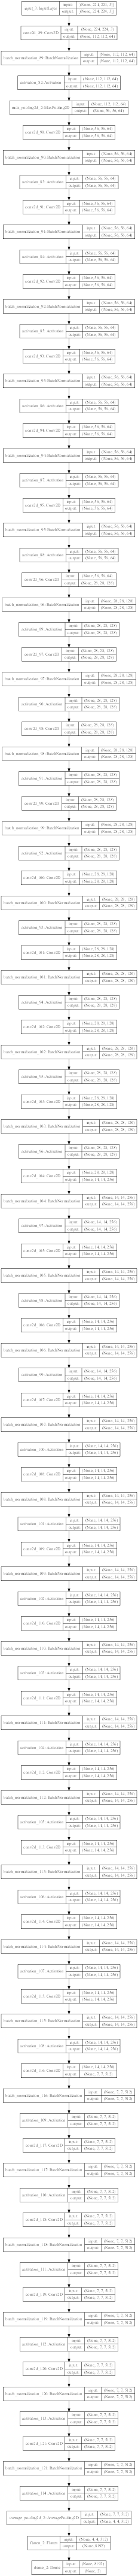

In [16]:
plot_model(model, show_shapes=True, dpi=36)

<br>

#### 모델 학습
***
+ Plain-34 모델을 학습합니다.


+ 손실 함수와 옵티마이저를 설정합니다.
***

In [17]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

plain_34_his = model.fit(
    ds_train,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(test_size/BATCH_SIZE),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
617/617 - 40s - loss: 0.8078 - accuracy: 0.4989 - val_loss: 0.9027 - val_accuracy: 0.5461
Epoch 2/30
617/617 - 34s - loss: 0.7105 - accuracy: 0.5112 - val_loss: 0.6956 - val_accuracy: 0.4987
Epoch 3/30
617/617 - 34s - loss: 0.6976 - accuracy: 0.5234 - val_loss: 0.7029 - val_accuracy: 0.4937
Epoch 4/30
617/617 - 34s - loss: 0.6883 - accuracy: 0.5532 - val_loss: 0.6883 - val_accuracy: 0.5545
Epoch 5/30
617/617 - 34s - loss: 0.6846 - accuracy: 0.5662 - val_loss: 0.7090 - val_accuracy: 0.5708
Epoch 6/30
617/617 - 34s - loss: 0.6721 - accuracy: 0.5947 - val_loss: 0.7067 - val_accuracy: 0.5258
Epoch 7/30
617/617 - 34s - loss: 0.6580 - accuracy: 0.6096 - val_loss: 0.9394 - val_accuracy: 0.5496
Epoch 8/30
617/617 - 34s - loss: 0.6484 - accuracy: 0.6268 - val_loss: 0.6936 - val_accuracy: 0.5916
Epoch 9/30
617/617 - 34s - loss: 0.6440 - accuracy: 0.6319 - val_loss: 1.6357 - val_accuracy: 0.5779
Epoch 10/30
617/617 - 34s - loss: 0.6359 - accuracy: 0.6403 - val_loss: 1.0078 - val_accura

<br>

### 4.3. Plain-50
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Plain-50 모델을 생성, 학습하고 평가합니다. 그 결과, 학습 데이터셋에 대한 손실 값은 최종 Epoch일 때 가장 낮았으며 0.6810입니다. 정확도의 경우 최종 Epoch일 때 가장 높았으며 0.5709입니다. 테스트 데이터셋에 대한 손실 값은 최종 Epoch일 때 가장 낮았으며  0.6902입니다. 정확도의 경우 최종 Epoch일 때 가장 높았으며 0.5496입니다.
</span>

<br><br>

<center><b>&lt;TRAIN 데이터셋에 대한 모델 결과></b></center>

|TRAIN Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.6810|0.5709|
|**Best**|0.6810|0.5709|

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 모델 결과></b></center>

|TEST Metrics|Loss|Acurracy|
|:---:|:---:|:---:|
|**Last**|0.6902|0.5496|
|**Best**|0.6902|0.5496|

***

<br>

#### 모델 생성 및 요약 시각화
***
+ Plain-50 모델을 생성하고 모델 요약을 시각화 합니다.
***

In [18]:
model = build_reset(input_shape=(224, 224, 3), is_50=True, is_resi=False)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256 

<br>

#### 모델 레이어 시각화
***
+ Plain-50 모델 구조를 시각화 합니다.
***

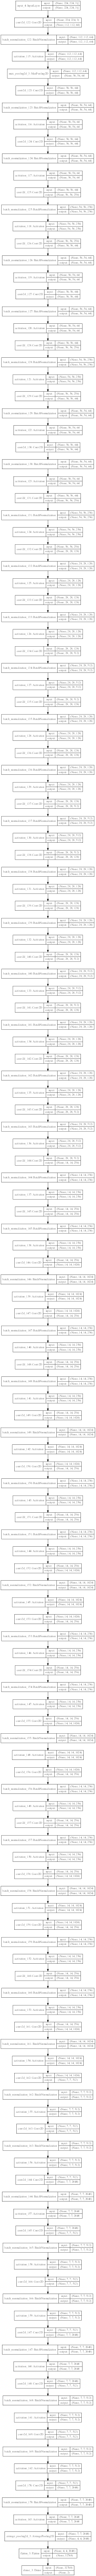

In [19]:
plot_model(model, show_shapes=True, dpi=36)

<br>

#### 모델 학습
***
+ Plain-50 모델을 학습합니다.


+ 손실 함수와 옵티마이저를 설정합니다.
***

In [20]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

plain_50_his = model.fit(
    ds_train,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(test_size/BATCH_SIZE),
    validation_data=ds_test,
    epochs=EPOCH,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/30
617/617 - 58s - loss: 1.0532 - accuracy: 0.5072 - val_loss: 11051.1758 - val_accuracy: 0.4942
Epoch 2/30
617/617 - 51s - loss: 0.7748 - accuracy: 0.5066 - val_loss: 0.8684 - val_accuracy: 0.5029
Epoch 3/30
617/617 - 51s - loss: 0.7576 - accuracy: 0.5071 - val_loss: 0.6947 - val_accuracy: 0.4903
Epoch 4/30
617/617 - 52s - loss: 0.7110 - accuracy: 0.4985 - val_loss: 0.6947 - val_accuracy: 0.5034
Epoch 5/30
617/617 - 51s - loss: 0.7009 - accuracy: 0.5028 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 6/30
617/617 - 51s - loss: 0.7002 - accuracy: 0.5078 - val_loss: 0.7031 - val_accuracy: 0.4968
Epoch 7/30
617/617 - 51s - loss: 0.6973 - accuracy: 0.4997 - val_loss: 0.6990 - val_accuracy: 0.4886
Epoch 8/30
617/617 - 51s - loss: 0.6950 - accuracy: 0.4964 - val_loss: 0.6961 - val_accuracy: 0.4796
Epoch 9/30
617/617 - 51s - loss: 0.6943 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5333
Epoch 10/30
617/617 - 51s - loss: 0.6941 - accuracy: 0.5011 - val_loss: 0.6967 - val_ac

<br>

### 4.4. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 테스트 데이터셋에 대한 각 모델의 손실값과 정확도를 비교한 결과, 'Resi-50`, 'Resi-34', 'Plain-34', 'Plain-50' 모델 순으로 성능이 높음을 확인하였습니다. 주목할 점은 'Plain-50' 모델이 'Plain-34' 모델에 비해 더 깊은 층을 가지고 있음에도 불구하고 성능이 좋지 않다는 것입니다. 우선 이는 과적합으로 인해 발생한 것이 아닌데, 다음의 '학습 히스토리 시각화'에 제시된 그래프에 의하면, 학습 데이터셋에 대한 'Plain-50'의 손실값 또한 특정 시점에서 더이상 감소하지 않기 때문에, 과적합 상황에서 발생하는 형태인 학습 데이터의 손실값은 지속적으로 감소하지만 검증 데이터셋 에대한 손실값은 상승하는 형태와는 다르다는 점에서 그 원인이 과적합에 있지 않다고 할 수 있습니다.
</span>

<br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 'Residual Model'을 제시한 Kaiming He 외 3인은 이와 같이 모델의 깊이가 깊어질수록 정확도가 감소하는 문제인 'Degradation'의 원인은 모델이 깊어질수록 경사가 소멸하거나 폭발하는 데에 있다고 지적하였습니다[1]. 그리고 이러한 문제를 해결하기 위해 중요한 특징(Identity Mapping)을 깊은 층에 전달하는 방식인 'Deep Residual Learning'을 제시하였습니다.
</span>

<br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이러한 내용을 바탕으로 데스트 데이터셋에 대한 각 모델의 손실값과 정확도를 확인하였을 때, 'Plain-34'에 비해 'Plain-50'의 성능 하락은 'degradation' 문제에 기반한 것이라 할 수 있습니다. 나아가 'Deep Residual Learning'을 사용한 'Res-34', 'Res-50' 모델에서 해당 문제를 해결하고 그 성능이 상승한 것을 확인할 수 있습니다.
</span>

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 손실값></b></center>

|TEST Loss|Res-34|Res-50|Plain-34|Plain-50|
|:---:|:---:|:---:|:---:|:---:|
|**BEST**|0.2548|**<span style="color:red">0.2257<span>**|0.3163|0.6902|
|**LAST 5 AVERAGE**|0.5075|**<span style="color:red">0.3188<span>**|0.5106|0.7759|

<br><br>

<center><b>&lt;TEST 데이터셋에 대한 정확도></b></center>

|TEST Loss|Res-34|Res-50|Plain-34|Plain-50|
|:---:|:---:|:---:|:---:|:---:|
|**BEST**|0.9217|**<span style="color:red">0.9306<span>**|0.8819|0.5496|
|**LAST 5 AVERAGE**|0.8936|**<span style="color:red">0.9010<span>**|0.8348|0.5116|

<br>
    
***

<br>

#### 학습 히스토리 시각화
***
+ 학습 데이터셋과 테스트 데이터셋에 대한 손실값과 정확도를 보여주는 학습 히스토리를 시각화 합니다.
***

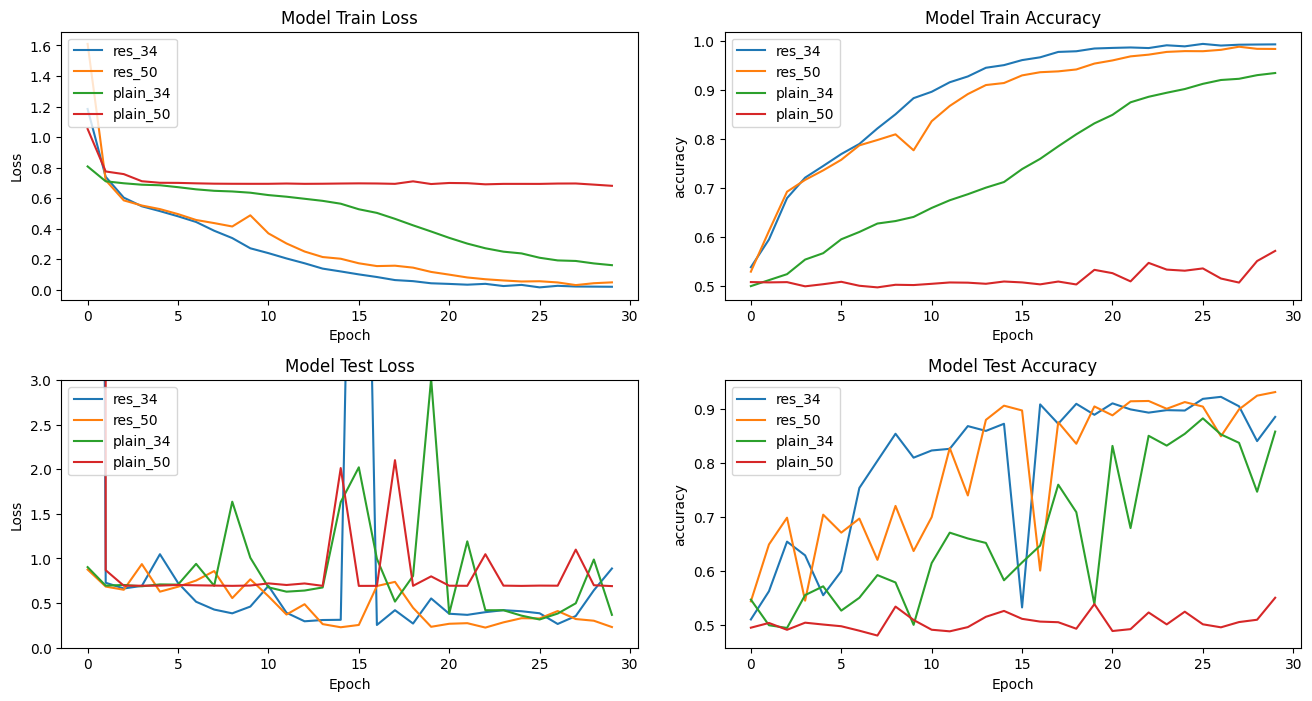

In [24]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.30)

plt.subplot(2, 2, 1)
for data in (res_34_his, res_50_his, plain_34_his, plain_50_his):
    plt.plot(data.history['loss'])
plt.title('Model Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res_34', 'res_50', 'plain_34', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 2)
for data in (res_34_his, res_50_his, plain_34_his, plain_50_his):
    plt.plot(data.history['accuracy'])
plt.title('Model Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['res_34', 'res_50', 'plain_34', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 3)
plt.ylim(0, 3.0)
for data in (res_34_his, res_50_his, plain_34_his, plain_50_his):
    plt.plot(data.history['val_loss'])
plt.title('Model Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['res_34', 'res_50', 'plain_34', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 4)
for data in (res_34_his, res_50_his, plain_34_his, plain_50_his):
    plt.plot(data.history['val_accuracy'])
plt.title('Model Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['res_34', 'res_50', 'plain_34', 'plain_50'], loc='upper left')

plt.show()

<br>

## 5. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp;  Kaiming He 외 3인이 『Deep Residual Learning for Image Recognition 』에서 제시한 'Plain' 모델과 'Residual' 모델의 성능 비교를, Tensorlflow에서 제공하는 'Cats_vs_Dogs' 데이터셋을 이용하여 재현하였습니다. 확인 결과 단순히 층만을 쌓은 'Plain-34'와 'Plain-50' 모델을 비교하였을 때, 더 깊은 모델인 'Plain-50'의 손실값이 더 높았습니다. 또한, 'Plain-50' 모델의 학습 데이터셋에 대한 손실값과 테스트 데이터셋에 대한 손실값 모두 더이상 감소하지 않는다는 점에서 이는 과적합이 아님을 확인하였습니다. 나아가 'Plain' 모델과 'Residual' 모델의 성능을 비교하였을 때, 'Residual' 모델의 경우가 더 좋았습니다. 또한, 더 깊은 'Res-50' 모델이 'Res-34' 모델에 비해 성능이 좋았으므로 'Deep Residual Learning'을 통해 'Degradation' 문제를 해결하였다고 할 수 있습니다.
</span>

***

<br>

참고문헌

***
[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).
***

<br>

#### 형상관리 기록
***
+ v1_1: 초기 예제


+ v1_2: Epoch 조절
***